In [1]:
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

Cloning into 'Self-Driving-Car-Simulator-Data'...
remote: Enumerating objects: 30625, done.
remote: Total 30625 (delta 0), reused 0 (delta 0), pack-reused 30625
Receiving objects: 100% (30625/30625), 389.44 MiB | 38.49 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (30632/30632), done.


In [0]:
!ls
!ls Self-Driving-Car-Simulator-Data

model.h5  sample_data  Self-Driving-Car-Simulator-Data
driving_log.csv  IMG  LICENSE  README.md


In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

In [0]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

def path_to_image(dir, line):
    filename = source_path.split('\\')[-1] 
    current_path = dir + filename
    return cv2.imread(current_path)

for line in lines:
    steering_center = float(line[3])
    
#     # create adjusted steering measurements for the side camera images
#     correction = 1 # this is a parameter to tune
#     steering_left = 1.5*steering_center + correction
#     steering_right = 1.5*steering_center - correction
            
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    
    image = cv2.imread(current_path)
    
    dir = 'Self-Driving-Car-Simulator-Data/IMG/'
    image_center = path_to_image(dir, line[0])
#     image_left   = path_to_image(dir, line[1])
#     image_right  = path_to_image(dir, line[2])
    
    images.append(image_center)
    measurement = float(line[3])
    measurements.append(measurement)
#     images.extend((image_center, image_left, image_right))
#     measurements.extend((steering_center, steering_left, steering_right))

# augmented_images = images
# augemented_measurements = measurements
# del images, measurements

augmented_images, augemented_measurements = [], []  
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augemented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augemented_measurements.append(-measurement)




In [0]:
def img_preprocess(img):
    img = img[60:135, :, :]                    # we don't need the top of the picture, because it is only terrian. 
                                               # We don't need also the bottom of the image, because it only the hood of the car
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Nvidia model needed this color space
    img = cv2.GaussianBlur(img, (3, 3), 0)     # Gaussian blur removes noise
    img = cv2.resize(img, (200, 66))
    img = img / 255 - 0.5
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.03773585


Text(0.5, 1.0, 'Preprocessed image')

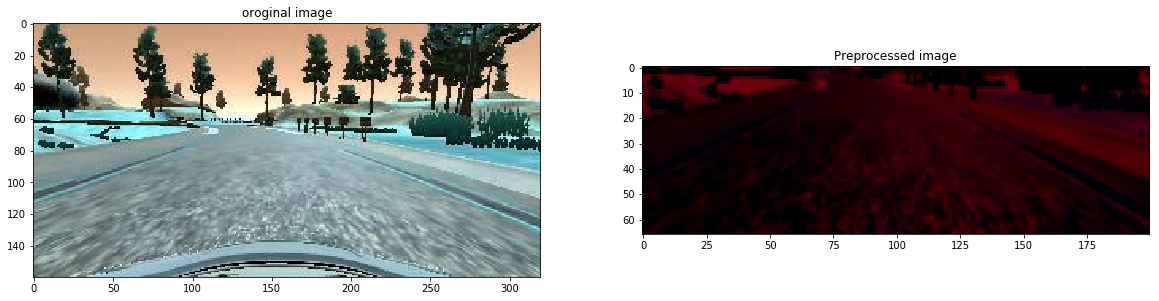

In [5]:
index = random.randint(0, len(measurements)-1)
# plt.imshow(images[index])
print(measurements[index])

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(images[index])
ax[0].set_title("oroginal image")
ax[1].imshow(img_preprocess(images[index]))
ax[1].set_title("Preprocessed image")

In [6]:
#clear RAM

# X_train = np.array(augmented_images)
y_train = np.array(augemented_measurements)

# X_train = np.array(list(map(img_preprocess, augmented_images)))    # iteratively goes through the whole array
X_train = np.zeros((len(augmented_images), 66, 200, 3))

del lines, images, measurements

for i in range(len(augmented_images)):
    X_train[i] = img_preprocess(augmented_images[i])

# X_train = np.array(img_preprocess(augmented_images))
# X_valid = np.array(list(map(img_preprocess, X_valid)))    # iteratively goes through the whole array
del augmented_images, augemented_measurements

print(X_train.shape)

(20418, 66, 200, 3)


In [8]:
model = Sequential()
# model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: (x), input_shape=(66, 200, 3)))
# model.add(Lambda(lambda x: (img_preprocess(x)), input_shape=(160, 320, 3)))
# model.add(Cropping2D(cropping=((70, 25),(0, 0))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = Adam(lr = 0.5e-3)
model.compile(loss='mse', optimizer=optimizer)
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 16334 samples, validate on 4084 samples
Epoch 1/7
16334/16334 [==============================] - 14s 828us/step - loss: 0.0301 - val_loss: 0.0297
Epoch 2/7
16334/16334 [==============================] - 7s 457us/step - loss: 0.0221 - val_loss: 0.0268
Epoch 3/7
16334/16334 [==============================] - 7s 457us/step - loss: 0.0199 - val_loss: 0.0271
Epoch 4/7
16334/16334 [==============================] - 7s 449us/step - loss: 0.0185 - val_loss: 0.0277
Epoch 5/7
16334/16334 [==============================] - 7s 434us/step - loss: 0.0177 - val_loss: 0.0274
Epoch 6/7
16334/16334 [==============================] - 7s 436us/step - loss: 0.0166 - val_loss: 0.0266
Epoch 7/7
16334/16334 [==============================] - 7s 443us/step - loss: 0.0167 - val_loss: 0.0263


dict_keys(['val_loss', 'loss'])


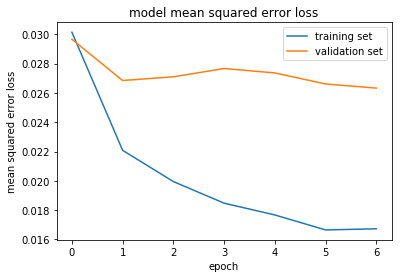

In [9]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')